| Nicola De Cristofaro (Matr. 0522500876) | Cloud Computing Curriculum |
| --- | --- |

# Data preparation: exploration and normalization

- The start point was to observe and analyze the tables in the dataset to understand how the data is distributed (Pandas libraries for Python is used to handle the tables as dataframes).
- The common functions of Pandas DataFrame to use for an overview of the table are the following:

  ``` python
  dataframe.info()
  dataframe.head()
  dataframe.describe()
  ```

- After reviewing the contents of the various tables in the MIMIC database, only some tables were selected and loaded into DataFrames using Pandas because it was assumed that it wasn't necessary or useful for prediction to include all tables. 

So the table selected that compose the baseline dataset are the following:
- **ADMISSIONS.csv** that defines a patient’s hospital admission,   
- **PATIENTS.csv** that defines a single patient, 
- **DIAGNOSES_ICD.csv** that contains ICD diagnoses for patients, most notably ICD-9 diagnoses (after this matter will be better explained),

Other tables will be considered, if necessary for the specific task.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### ADMISSIONS table

In [2]:
mimic4_path = '../../mimic-iv-2.2/'

# read admissions table
def read_admissions_table(mimic4_path):
    admits = pd.read_csv(mimic4_path + 'hosp/admissions.csv')
    # Pre-emptively don't include some columns that I don't need
    # TODO we have more colums
    admits = admits[['subject_id','hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'insurance', 'race']]
    # Converts dates to a proper format
    admits.admittime = pd.to_datetime(admits.admittime)
    admits.dischtime = pd.to_datetime(admits.dischtime)
    admits.deathtime = pd.to_datetime(admits.deathtime)
    return admits

admits = read_admissions_table(mimic4_path)
admits.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,insurance,race
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,URGENT,Other,WHITE
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,EW EMER.,Medicaid,WHITE
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,EW EMER.,Medicaid,WHITE
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EW EMER.,Medicaid,WHITE
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaT,EU OBSERVATION,Other,WHITE


In [3]:
admits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431231 entries, 0 to 431230
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   subject_id      431231 non-null  int64         
 1   hadm_id         431231 non-null  int64         
 2   admittime       431231 non-null  datetime64[ns]
 3   dischtime       431231 non-null  datetime64[ns]
 4   deathtime       8598 non-null    datetime64[ns]
 5   admission_type  431231 non-null  object        
 6   insurance       431231 non-null  object        
 7   race            431231 non-null  object        
dtypes: datetime64[ns](3), int64(2), object(3)
memory usage: 26.3+ MB


When DEATHTIME in ADMISSIONS is not null then the patient associated died at the hospital, so we mark this distinction with a boolean variable.

In [4]:
admits['died_at_the_hospital'] = admits['deathtime'].notnull().map({True:1, False:0})

#### Reduction number of categories

In [5]:
# ETHNICITY
admits['race'].value_counts()

WHITE                                        272932
BLACK/AFRICAN AMERICAN                        59959
OTHER                                         15102
UNKNOWN                                       10668
HISPANIC/LATINO - PUERTO RICAN                 8076
WHITE - OTHER EUROPEAN                         7925
HISPANIC OR LATINO                             7754
ASIAN                                          6156
ASIAN - CHINESE                                5587
WHITE - RUSSIAN                                5024
BLACK/CAPE VERDEAN                             4765
HISPANIC/LATINO - DOMINICAN                    4383
BLACK/CARIBBEAN ISLAND                         2704
BLACK/AFRICAN                                  2530
PATIENT DECLINED TO ANSWER                     1761
UNABLE TO OBTAIN                               1603
PORTUGUESE                                     1510
ASIAN - SOUTH EAST ASIAN                       1446
HISPANIC/LATINO - GUATEMALAN                   1330
ASIAN - ASIA

We could reduce the number of categoruies just by considering the main categories or super-categories.

In [6]:
# Compress the number of ethnicity categories
admits['race'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
admits['race'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
admits['race'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
admits['race'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
admits['race'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
#take into consideration just the top-5 categories with biggest value_count, the others will fall into OTHER category
admits['race'].loc[~admits['race'].isin(admits['race'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'  
admits['race'].value_counts()

/tmp/ipykernel_5187/224434352.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admits['race'].loc[~admits['race'].isin(admits['race'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'


WHITE                     288154
BLACK/AFRICAN AMERICAN     69958
OTHER/UNKNOWN              33014
HISPANIC/LATINO            25212
ASIAN                      14893
Name: race, dtype: int64

Now let's do the same analysis done for ETHNICITY also for other attributes, if necessary, to reduce the number of possible categories.

In [7]:
# ADMISSION_TYPE
admits['admission_type'].value_counts()

EW EMER.                       149413
EU OBSERVATION                  94776
OBSERVATION ADMIT               52668
URGENT                          44691
SURGICAL SAME DAY ADMISSION     34231
DIRECT EMER.                    19554
DIRECT OBSERVATION              18707
ELECTIVE                        10565
AMBULATORY OBSERVATION           6626
Name: admission_type, dtype: int64

The category URGENT is a lot similar semantically to EMERGENCY or DIRECT EMERGENCY, so could combine these categories in EMERGENCY. We could do the same process also for all those categories that are related to OBSERVATION.

In [8]:
# Compresse into EMERGENCY
admits['admission_type'].replace(to_replace='EW EMER.', value='EMERGENCY', inplace=True)
admits['admission_type'].replace(to_replace='DIRECT EMER.', value='EMERGENCY', inplace=True)
admits['admission_type'].replace(to_replace='URGENT', value='EMERGENCY', inplace=True)
admits['admission_type'].value_counts()

EMERGENCY                      213658
EU OBSERVATION                  94776
OBSERVATION ADMIT               52668
SURGICAL SAME DAY ADMISSION     34231
DIRECT OBSERVATION              18707
ELECTIVE                        10565
AMBULATORY OBSERVATION           6626
Name: admission_type, dtype: int64

In [9]:
# Compresse into EMERGENCY
admits['admission_type'].replace(to_replace='EU OBSERVATION', value='OBSERVATION', inplace=True)
admits['admission_type'].replace(to_replace='OBSERVATION ADMIT', value='OBSERVATION', inplace=True)
admits['admission_type'].replace(to_replace='DIRECT OBSERVATION', value='OBSERVATION', inplace=True)
admits['admission_type'].replace(to_replace='AMBULATORY OBSERVATION', value='OBSERVATION', inplace=True)
admits['admission_type'].value_counts()

EMERGENCY                      213658
OBSERVATION                    172777
SURGICAL SAME DAY ADMISSION     34231
ELECTIVE                        10565
Name: admission_type, dtype: int64

### PATIENTS table


In [18]:
# read patients table
def read_patients_table(mimic4_path):
    pats = pd.read_csv(mimic4_path + 'hosp/patients.csv')
    # Pre-emptively don't include some columns that I don't need
    pats = pats[['subject_id', 'gender', 'anchor_age', 'dod']]
    pats.dod = pd.to_datetime(pats.dod)
    return pats

patients = read_patients_table(mimic4_path)
patients.head()

,subject_id,gender,anchor_age,dod
0,10000032,F,52,2180-09-09
1,10000048,F,23,NaT
2,10000068,F,19,NaT
3,10000084,M,72,2161-02-13
4,10000102,F,27,NaT


In PATIENTS table we have now the age of the patient and this is a news in comparison to MIMIC-3 where the age of the patient had to be computed.

So, let's have a look on the age distribution between patients.

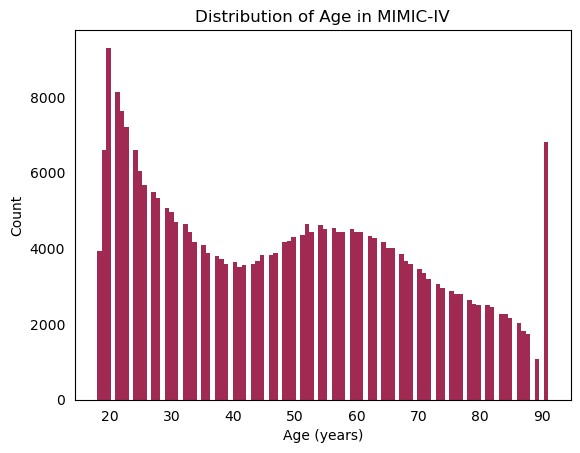

In [19]:
# DOB has been shifted for patients older than 89 to obscure their age and comply with HIPAA, the median age for the patients whose date of birth was shifted is 91.4

#let's see the distribution of age
plt.hist(patients['anchor_age'], bins=100, color='#a12a52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show()

As we can see from age distribution, patients in their childhood are not present, this reflects the fact that MIMIC-IV as MIMIC-III does not contain data from pediatric patients.

Let's see also the distribution of gender.

In [20]:
patients['gender'].value_counts()

F    158553
M    141159
Name: gender, dtype: int64

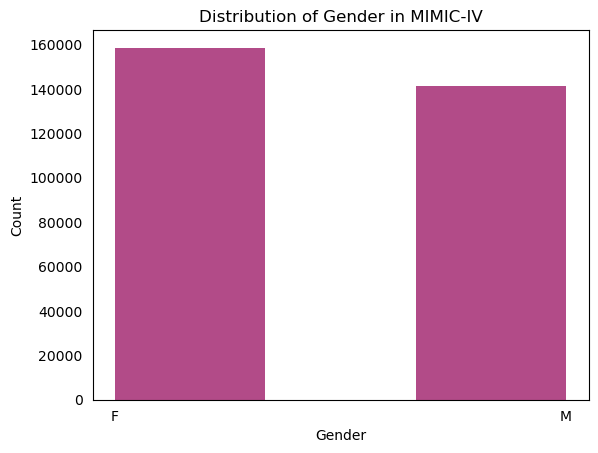

In [21]:
# distribution of gender
plt.hist(patients['gender'], bins=3, color='#b24b88')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.title('Distribution of Gender in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show()

Wee can see how the gender is almost equally balanced.

Now we merge patients and admissions tables on 'subject_id' link.

In [22]:
# merge the PATIENTS table with ADMISSIONS table
admits_patients = pd.merge(admits, patients, how='inner', on='subject_id')
admits_patients.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,insurance,race,died_at_the_hospital,gender,anchor_age,dod
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,EMERGENCY,Other,WHITE,0,F,52,2180-09-09
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,EMERGENCY,Medicaid,WHITE,0,F,52,2180-09-09
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,EMERGENCY,Medicaid,WHITE,0,F,52,2180-09-09
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EMERGENCY,Medicaid,WHITE,0,F,52,2180-09-09
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaT,OBSERVATION,Other,WHITE,0,F,19,NaT


### DIAGNOSES_ICD table

In [23]:
# read diagnoses_icd table
def read_diagnoses_icd_table(mimic4_path):
    diag_icds = pd.read_csv(mimic4_path + 'hosp/diagnoses_icd.csv')
    return diag_icds

diag_icds = read_diagnoses_icd_table(mimic4_path)
diag_icds.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [24]:
diag_icds.count()

subject_id     4756326
hadm_id        4756326
seq_num        4756326
icd_code       4756326
icd_version    4756326
dtype: int64

In [25]:
diag_icds.icd_version.value_counts()

9     2766877
10    1989449
Name: icd_version, dtype: int64

We can notice that there are two version of icd_code: version 9 and 10. In general, ICD-10 codes are more detailed, but they could be mapped and converted to ICD-9 because they expresse the same concept.

Since we are dealing with a dataframe with a lot of entries and in any case it should later be reduced in size for a faster test, for simplicity we consider only the diagnoses with ICD9 codes.

In [26]:
diag_icds = diag_icds[diag_icds['icd_version'] == 9]
diag_icds.icd_version.value_counts()

9    2766877
Name: icd_version, dtype: int64

International Classification of Diseases, Clinical Modification (ICD-CM in version 9 and 10) is an adaption created by the U.S. National Center for Health Statistics (NCHS) and used in assigning diagnostic and procedure codes associated with inpatient, outpatient, and physician office utilization in the United States.

In [27]:
print('There are {} unique ICD9 codes in this dataset.'.format(diag_icds['icd_code'].value_counts().count()))

There are 9072 unique ICD9 codes in this dataset.


Because it's not feasible to have all these unique values to use as features for predicting LOS, it is necessary to reduce the diagnosis into more general categories. After researching the ICD9 and ICD10 approach, it's been noticed that they are arranged into super categories as described at the following links:

- **ICD-9 codes supercategories**: https://en.wikipedia.org/wiki/List_of_ICD-9_codes
- **ICD-10 codes supercategories**: https://en.wikipedia.org/wiki/ICD-10#Chapters

From this research we see that our attention could be just on the first 3 values to discover the supercategory. So our task now is to recode each ICD code considedred to its supercategory.

In [40]:
# Filter out E and V codes from ICD9 codes since processing will be done on the numeric first 3 values
diag_icds['recode'] = diag_icds['icd_code']
diag_icds['recode'] = diag_icds['recode'][~diag_icds['recode'].str.contains("[a-zA-Z]").fillna(False)]
diag_icds['recode'].fillna(value='999', inplace=True)

# Take in consideration just the first 3 integers of the ICD9 code
diag_icds['recode'] = diag_icds['recode'].str.slice(start=0, stop=3, step=1)
diag_icds['recode'] = diag_icds['recode'].astype(int)
diag_icds.head(10)

,subject_id,hadm_id,seq_num,icd_code,icd_version,recode,super_category
0,10000032,22595853,1,5723,9,572,infectious
1,10000032,22595853,2,78959,9,789,infectious
2,10000032,22595853,3,5715,9,571,infectious
3,10000032,22595853,4,07070,9,70,infectious
4,10000032,22595853,5,496,9,496,infectious
5,10000032,22595853,6,29680,9,296,infectious
6,10000032,22595853,7,30981,9,309,infectious
7,10000032,22595853,8,V1582,9,999,infectious
8,10000032,22841357,1,07071,9,70,infectious
9,10000032,22841357,2,78959,9,789,infectious


In [41]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    diag_icds['recode'] = np.where(diag_icds['recode'].between(cat_range[0],cat_range[1]), num, diag_icds['recode'])
    
# Convert integer to category name using diag_dict
diag_icds['super_category'] = diag_icds['recode'].replace(diag_dict)
diag_icds.head(40)


,subject_id,hadm_id,seq_num,icd_code,icd_version,recode,super_category
0,10000032,22595853,1,5723,9,8,digestive
1,10000032,22595853,2,78959,9,15,misc
2,10000032,22595853,3,5715,9,8,digestive
3,10000032,22595853,4,07070,9,0,infectious
4,10000032,22595853,5,496,9,7,respiratory
5,10000032,22595853,6,29680,9,4,mental
6,10000032,22595853,7,30981,9,4,mental
7,10000032,22595853,8,V1582,9,16,injury
8,10000032,22841357,1,07071,9,0,infectious
9,10000032,22841357,2,78959,9,15,misc


In [45]:
diag_icds.super_category.value_counts()

injury           614305
circulatory      458774
endocrine        327549
mental           187943
digestive        184372
misc             161741
genitourinary    136235
nervous          133664
muscular         105518
respiratory      104476
blood             85264
neoplasms         68944
infectious        65174
pregnancy         45114
skin              43603
prenatal          37503
congenital         6698
Name: super_category, dtype: int64

For each admission, usually there is more than one diagnosis. Often, there are more than 1 diagnoses for 1 category. 

We could create a matrix that highlights all the diagnoses for each admission. This should not be done on the SUBJECT_ID since each patient could have different diagnoses for each admission.

In [46]:
# Create list of diagnoses for each admission
hadm_list = diag_icds.groupby('hadm_id')['super_category'].apply(list).reset_index()
hadm_list.head()

,hadm_id,super_category
0,20000019,"[infectious, genitourinary, congenital, genito..."
1,20000041,"[muscular, endocrine, injury, circulatory, end..."
2,20000057,"[muscular, muscular, injury, injury, injury, r..."
3,20000102,"[pregnancy, injury, injury]"
4,20000235,"[digestive, circulatory, digestive, genitourin..."


In [47]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['super_category'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head()

/tmp/ipykernel_5187/2640996392.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  hadm_item = pd.get_dummies(hadm_list['super_category'].apply(pd.Series).stack()).sum(level=0)


,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,1,1,1,0,3,2,1,2,0,0,0,0,0,0,0,1,0
1,0,1,0,1,3,0,0,4,0,0,1,0,0,0,0,0,0
2,1,1,0,0,1,0,0,7,0,1,5,0,4,0,1,2,0
3,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0
4,1,6,0,4,2,1,1,2,0,0,0,0,0,0,0,0,1


In [48]:
# Join back with HADM_ID
hadm_item = hadm_item.join(hadm_list['hadm_id'], how="outer")

In [49]:
# Merge with main dataframe
admits_patients_diag = pd.merge(admits_patients, hadm_item, how='inner', on='hadm_id')
admits_patients_diag.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,insurance,race,died_at_the_hospital,gender,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,EMERGENCY,Other,WHITE,0,F,...,1,2,1,0,0,0,0,0,1,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,EMERGENCY,Medicaid,WHITE,0,F,...,1,1,1,0,0,0,0,0,1,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,EMERGENCY,Medicaid,WHITE,0,F,...,2,1,2,0,0,0,0,0,1,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EMERGENCY,Medicaid,WHITE,0,F,...,3,2,2,0,0,0,0,0,1,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaT,OBSERVATION,Other,WHITE,0,F,...,0,1,0,0,0,0,0,0,0,0


In [50]:
# save this version of the dataframe to a csv. It will be used as baseline for our prediction tasks
admits_patients_diag.to_csv('admits_patients_diag.csv')